In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM


from scipy import stats


import random

import warnings  
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [10]:
def trainModel(train):
    """
    Training LSTM model
    input:
        train: training dataframe
    output:
        lstm_model: trained lstm model
    """
    
    #scaling => translates each feature individually such that it is in the given range on the training set
    #to ensure the unit if our data is not a factor

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_sc = scaler.fit_transform(train)

    #Reshaping the data to work for an LSTM network

    train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)


    for s in range(1,2):
        train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)

    X_train = train_sc_df.dropna().drop('Y', axis=1)
    y_train = train_sc_df.dropna().drop('X_1', axis=1)


    X_train = X_train.as_matrix()
    y_train = y_train.as_matrix()


    X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
   

    print('Train shape: ', X_train_lmse.shape)
    

    lstm_model = Sequential()
    lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
    history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=10, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

    return lstm_model

def testModel(lstm_model,test):
    """
    Testing the LSTM model
    input:
        test: testing dataframe
        lstm_model: trainied lstm model
    output:
        lstm_pred: inverse scaled dataframe of predicted values
        test_val: inverse scaled dataframe of original values
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    test_sc = scaler.fit_transform(test)
    X_test = test_sc[:-1]
    y_test = test_sc[1:]
    test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)
    for s in range(1,2):
        test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)


    X_test = test_sc_df.dropna().drop('Y', axis=1)
    y_test = test_sc_df.dropna().drop('X_1', axis=1)

    X_test = X_test.as_matrix()
    y_test = y_test.as_matrix()
    
    X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    #print(X_test_lmse)
    y_pred_test_lstm = lstm_model.predict(X_test_lmse)
    
    #print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
    
    lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
   
    print('LSTM: %f'%lstm_test_mse)
    
    #inversing the scaling
    lstm_pred = scaler.inverse_transform(y_pred_test_lstm)
    test_val = scaler.inverse_transform(y_test)
    
    return lstm_pred, test_val


def trainingData():
    """
    Reading Train Data 
    input:
        none
    output:
        data: training dataframe with index => DisplayTime value => GlucoseValues
    """
    
    data = pd.read_csv("~/Desktop/NCSA_genomics/Data/data_hall.txt", sep="\t") #use your path
    #data.head()
    data['Display Time'] = data['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    data['time_gap'] = data['Display Time']- data['Display Time'].shift(1)
    meta = pd.read_csv("~/Desktop/NCSA_genomics/Data/Hall_meta.csv") 
    for subjectId, df in data.groupby('subjectId'):
        print("==============================================================")
        print("Subject ID: "+str(subjectId))
        temp = meta[meta["ID"]==subjectId]
        print("Status: "+str(temp["status"].values[0]))
        #print(df)
        #print(df['GlucoseValue'].describe())
        #100*(len(df[df["time_gap"]>str("00:05:00")])/df['GlucoseValue'].count())
        print("Length of the readings: "+str(df['GlucoseValue'].count()))
        print("Max. Glucose value: "+str(df['GlucoseValue'].max()))
        print("Min. Glucose value: "+str(df['GlucoseValue'].min()))
        print("Mean Glucose value: "+str(round(df['GlucoseValue'].mean(),3)))
        print("Missing Values: "+str(len(df[df["time_gap"]>str("00:05:00")])))
        print("Percent of missing values: "+str(round(100*(len(df[df["time_gap"]>str("00:05:00")])/df['GlucoseValue'].count()),2))+"%")
        #print(df['DisplayTime'])
        print()
        print("Days: "+str(df['Display Time'].iloc[-1]-df['Display Time'].iloc[0]))
    
    #dropping columns we don't need
    
    
    data.drop(['subjectId', 'Internal Time', 'time_gap'], axis=1, inplace=True)
    
    #Converting the Display Time to 'datetime' so that it can be used as an index
    #data['Display Time'] = data['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    data = data.set_index(['Display Time'], drop=True)
    #data.head()
    
    return data

def testingData():
    """
    Reading Test Data 
    input:
        none
    output:
        data: testing dataframe with index => DisplayTime value => GlucoseValues
    """
    #reading datasets for training
    data = pd.read_csv("~/Desktop/NCSA_genomics/Data/CGManalyzer.csv")

    diabetic_1 = data[data['ID'] == "ID01"]
    diabetic_2 = data[data['ID'] == "ID11"]
    prediabetic = data[data['ID'] == "ID21"]
    nondiabetic = data[data['ID'] == "ID29"]
    
#     diabetic_1 = pd.read_csv("/Users/snehgajiwala/Desktop/NCSA_genomics/Data/CGManalyzer-datasets/test/ID01.csv")
#     diabetic_2 = pd.read_csv("/Users/snehgajiwala/Desktop/NCSA_genomics/Data/CGManalyzer-datasets/test/ID11.csv")
#     prediabetic = pd.read_csv("/Users/snehgajiwala/Desktop/NCSA_genomics/Data/CGManalyzer-datasets/test/ID21.csv")
#     nondiabetic = pd.read_csv("/Users/snehgajiwala/Desktop/NCSA_genomics/Data/CGManalyzer-datasets/test/ID29.csv")
    
    #Converting the Display Time to 'timeStamp' so that it can be used as an index
    diabetic_1['timeStamp'] = diabetic_1['timeStamp'].apply(lambda x: pd.datetime.strptime(x, '%Y:%m:%d:%H:%M'))
    diabetic_1.drop(['ID'], axis=1, inplace=True)
    diabetic_1 = diabetic_1.set_index(['timeStamp'], drop=True)
    
    prediabetic['timeStamp'] = prediabetic['timeStamp'].apply(lambda x: pd.datetime.strptime(x, '%Y:%m:%d:%H:%M'))
    prediabetic.drop(['ID'], axis=1, inplace=True)
    prediabetic = prediabetic.set_index(['timeStamp'], drop=True)
    
    nondiabetic['timeStamp'] = nondiabetic['timeStamp'].apply(lambda x: pd.datetime.strptime(x, '%Y:%m:%d:%H:%M'))
    nondiabetic.drop(['ID'], axis=1, inplace=True)
    nondiabetic = nondiabetic.set_index(['timeStamp'], drop=True)
    
    diabetic_2['timeStamp'] = diabetic_2['timeStamp'].apply(lambda x: pd.datetime.strptime(x, '%Y:%m:%d:%H:%M'))
    diabetic_2.drop(['ID'], axis=1, inplace=True)
    diabetic_2 = diabetic_2.set_index(['timeStamp'], drop=True)
    
    return diabetic_1, diabetic_2, prediabetic, nondiabetic
    
    

def plot(lstm_pred, test_val):
    #plotting true values and lstm predicted values
    #these are original values
    
    plt.figure(figsize=(20, 8))
    
    
    plt.plot(lstm_pred, label='LSTM', color='red', linewidth=2)
    plt.plot(test_val, label='True', color='#2280f2', linewidth=2.5)
    
    plt.title("LSTM's Prediction")
    
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.legend()
    plt.show();
    
def getMetrics(lstm_pred, test_val):
    #IOA
    ioa_val = index_agreement(lstm_pred,test_val)
    print("Index of Agreement is: " + str(round(ioa_val,3)))

    #MAE
    mae_val = mae(lstm_pred,test_val)
    print("Mean Absolute Error is: " + str(mae_val))

    #RMSE
    rmse_val = rmse(lstm_pred,test_val)
    print("Root Mean Squared Error is: " + str(round(rmse_val,3)))
    
    #MAD
    mad_val = mad(lstm_pred)
    print("Mean Absolute Difference is: " + str(mad_val))
    
    #FB
    fb_val = fracBias(lstm_pred,test_val)
    print("Fractional Bias is: " + str(round(fb_val,3)))
    
    #MAPE
    mape_val = mape(lstm_pred,test_val)
    print("Mean Absolute Percentage Error is: " + str(round(mape_val)))
    
    
def index_agreement(s,o):
    """
    index of agreement
    input:
        s: prediceted
        o: original
    output:
        ia: index of agreement
    """
    
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    
    return ia

def rmse(s,o):
    """
    Root Mean Squared Error
    input:
        s: prediceted
        o: original
    output:
        rmses: root mean squared error
    """
    return np.sqrt(np.mean((s-o)**2))

def mae(s,o):
    """
    Mean Absolute Error
    input:
        s: prediceted
        o: original
    output:
        maes: mean absolute error
    """
    return np.mean(abs(s-o))

def mad(s):
    """
    Mean Absolute Difference
    input:
        s: prediceted
    output:
        mad: mean absolute error
    """
  
    return stats.median_absolute_deviation(s)
    


def mape(y_pred,y_true):
    """
    Mean Absolute Percentage error
    input:
        y_pred: prediceted
        y_true: original
    output:
        mape: Mean Absolute Percentage error
    """

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def fracBias(s,o):
    """
    Fractional Bias
    input:
        s: prediceted
        o: original
    output:
        fracBias: Fractional Bias
    """
    
    return np.mean(np.abs((o - s) / ((o + s)/2)))



def createGap(data):
    """
    Creating Gap indexes
    input:
        data: dataframe with index => DisplayTime value => GlucoseValues
    output:
        start: seed
        end: seed+gap (gap=300)
    """
    
    seed = random.randint(500,len(data)-500)
    
    return seed,seed+500


def faultyData(df,start,end):
    """
    Creating a Gap
    input:
        start: seed
        end: seed+gap (gap=300)
    output:
        df: dataframe with index => DisplayTime value => GlucoseValues and a gap from start to end (inputs)
    """
    
    #df = readData()
    for i in range(start,end):
        df['glucoseValue'][i]=0
    
    return df


def summaryPlot(p1,t1,p2,t2,p3,t3,p4,t4):
    
    plt.figure(figsize=(20, 20))

    plt.subplot(2, 2, 1)
    plt.plot(p1, label='LSTM', color='red', linewidth=2)
    plt.plot(t1, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Diabetic - 1")
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(p2, label='LSTM', color='red', linewidth=2)
    plt.plot(t2, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Diabetic - 2")
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(p3, label='LSTM', color='red', linewidth=2)
    plt.plot(t3, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Prediabetic")
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(p4, label='LSTM', color='red', linewidth=2)
    plt.plot(t4, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Nondiabetic")
    plt.legend()
    
    
    plt.show();
    

In [3]:
#generating the training set
train_set = trainingData()
#print(train_set)


Subject ID: 1636-69-026
Status: pre-diabetic
Length of the readings: 1796
Max. Glucose value: 182
Min. Glucose value: 62
Mean Glucose value: 115.156
Missing Values: 78
Percent of missing values: 4.34%

Days: 7 days 01:29:34
Subject ID: 1636-69-028
Status: non-diabetic
Length of the readings: 1822
Max. Glucose value: 216
Min. Glucose value: 55
Mean Glucose value: 115.385
Missing Values: 72
Percent of missing values: 3.95%

Days: 75 days 07:45:22
Subject ID: 1636-69-032
Status: pre-diabetic
Length of the readings: 1783
Max. Glucose value: 191
Min. Glucose value: 67
Mean Glucose value: 108.316
Missing Values: 29
Percent of missing values: 1.63%

Days: 6 days 04:34:32
Subject ID: 1636-69-035
Status: non-diabetic
Length of the readings: 2180
Max. Glucose value: 234
Min. Glucose value: 69
Mean Glucose value: 116.556
Missing Values: 137
Percent of missing values: 6.28%

Days: 11 days 01:04:20
Subject ID: 1636-69-048
Status: non-diabetic
Length of the readings: 1779
Max. Glucose value: 144
Min

Days: 6 days 04:34:44
Subject ID: 2133-010
Status: non-diabetic
Length of the readings: 1832
Max. Glucose value: 143
Min. Glucose value: 62
Mean Glucose value: 93.408
Missing Values: 80
Percent of missing values: 4.37%

Days: 6 days 17:29:32
Subject ID: 2133-011
Status: non-diabetic
Length of the readings: 1933
Max. Glucose value: 204
Min. Glucose value: 47
Mean Glucose value: 95.197
Missing Values: 78
Percent of missing values: 4.04%

Days: 9 days 05:54:03
Subject ID: 2133-012
Status: non-diabetic
Length of the readings: 1935
Max. Glucose value: 148
Min. Glucose value: 49
Mean Glucose value: 96.023
Missing Values: 53
Percent of missing values: 2.74%

Days: 12 days 10:14:03
Subject ID: 2133-013
Status: non-diabetic
Length of the readings: 1960
Max. Glucose value: 206
Min. Glucose value: 41
Mean Glucose value: 96.813
Missing Values: 128
Percent of missing values: 6.53%

Days: 8 days 07:49:13
Subject ID: 2133-015
Status: pre-diabetic
Length of the readings: 1835
Max. Glucose value: 213
M

In [4]:
#Training the model on all the data in the HAL dataset
#That is, one row observed as diabetic, prediabetic and non-diabetic each has been explicitly removed
#The model has thus, never sen the test data

In [5]:
lstmModel = trainModel(train_set)

Train shape:  (103579, 1, 1)
Epoch 1/10
103579/103579 [==============================] - 241s 2ms/step - loss: 3.8498e-04
Epoch 2/10
103579/103579 [==============================] - 274s 3ms/step - loss: 3.5122e-04
Epoch 3/10
103579/103579 [==============================] - 403s 4ms/step - loss: 3.4704e-04
Epoch 4/10
103579/103579 [==============================] - 349s 3ms/step - loss: 3.4411e-04
Epoch 5/10
103579/103579 [==============================] - 374s 4ms/step - loss: 3.4155e-04
Epoch 6/10
103579/103579 [==============================] - 227s 2ms/step - loss: 3.3944e-04
Epoch 7/10
103579/103579 [==============================] - 208s 2ms/step - loss: 3.3712e-04
Epoch 8/10
103579/103579 [==============================] - 200s 2ms/step - loss: 3.3544e-04
Epoch 9/10
103579/103579 [==============================] - 209s 2ms/step - loss: 3.3390e-04
Epoch 10/10
103579/103579 [==============================] - 211s 2ms/step - loss: 3.3272e-04


In [6]:
#extracting data for testing the data and creating a gap of missing values
#predicting the missing values 
#plotting the graph for the same

In [11]:
diabetic_1, diabetic_2 , prediabetic, non_diabetic = testingData()#these time series' data will be used to plot comparison graphs
diabetic_1_faulty, diabetic_2_faulty, prediabetic_faulty, non_diabetic_faulty = testingData()#gaps will be introduced in these time series' for imputations 

In [12]:
start, end = createGap(diabetic_1)
gap_tester_diabetic_1 = diabetic_1.iloc[start:end+2]
diabetic_1_faulty = faultyData(diabetic_1_faulty,start,end+1)

501/501 [==============================] - 0s 926us/step
LSTM: 0.003668


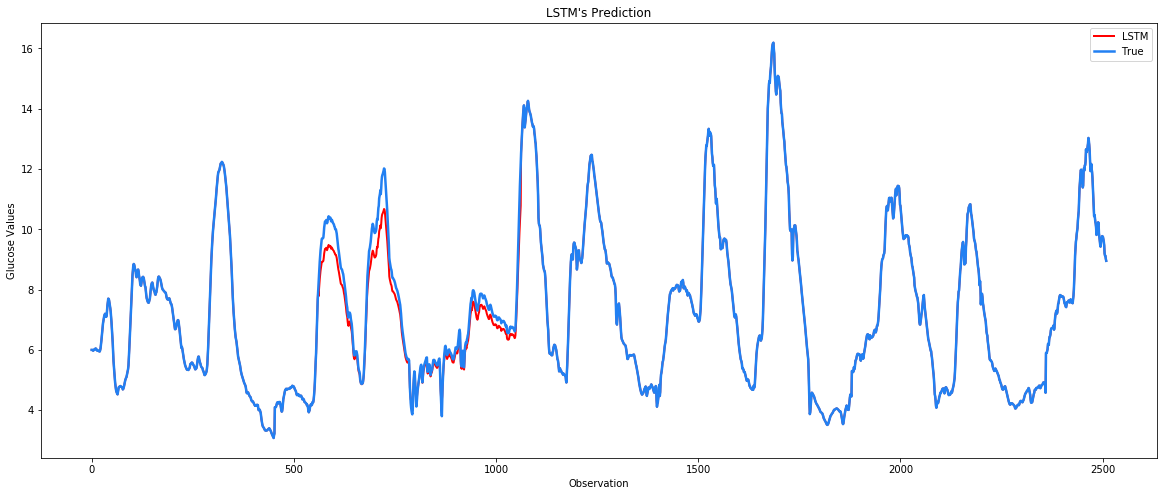

Index of Agreement is: 0.977
Mean Absolute Error is: 0.40412564270415463
Root Mean Squared Error is: 0.529
Mean Absolute Difference is: [1.7333943]
Fractional Bias is: 0.051
Mean Absolute Percentage Error is: 5.0


In [13]:
#here, we're actually running the model and getting the imputed values for the gap
predicted, true = testModel(lstmModel,gap_tester_diabetic_1)
#here we are are filling in the gap we created with imputed values generated by the model
for i in range(0,501):
     diabetic_1_faulty['glucoseValue'][start+i] = predicted[i][0]

plot(diabetic_1_faulty['glucoseValue'].tolist(),diabetic_1['glucoseValue'].tolist())
getMetrics(predicted,true)
diabetic_1_faulty.to_csv("~/Desktop/NCSA_genomics/Data/outputs/CGM_diabetic-1_imputed.csv")

In [14]:
#repeating the same for diabetic type 2
start, end = createGap(diabetic_2)
gap_tester_diabetic_2 = diabetic_2.iloc[start:end+2]
diabetic_2_faulty = faultyData(diabetic_2_faulty,start,end+1)

501/501 [==============================] - 0s 816us/step
LSTM: 0.004122


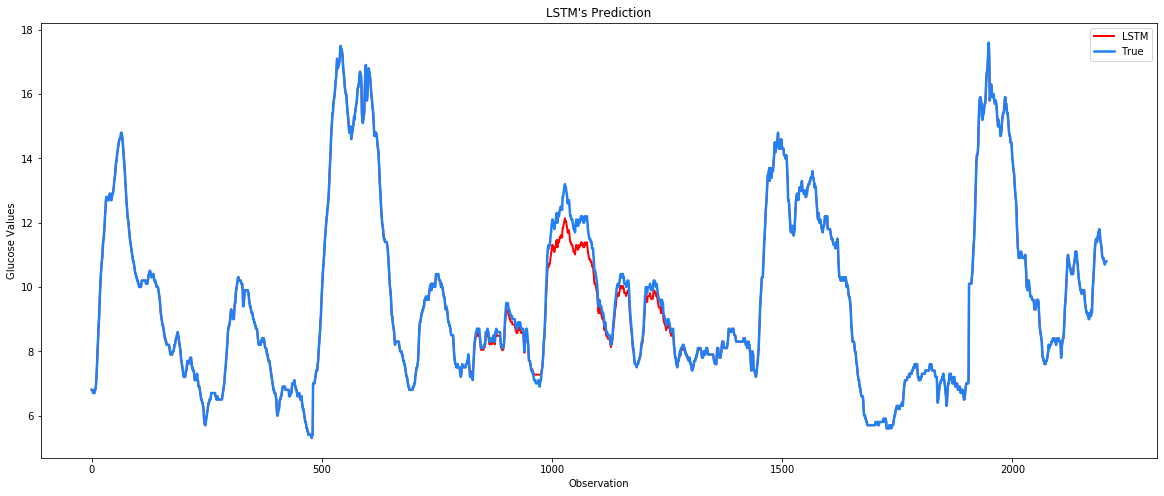

Index of Agreement is: 0.981
Mean Absolute Error is: 0.29316899191119705
Root Mean Squared Error is: 0.404
Mean Absolute Difference is: [1.2994037]
Fractional Bias is: 0.029
Mean Absolute Percentage Error is: 3.0


In [15]:
predicted, true = testModel(lstmModel,gap_tester_diabetic_2)

for i in range(0,501):
    diabetic_2_faulty['glucoseValue'][start+i] = predicted[i][0]
    
plot(diabetic_2_faulty['glucoseValue'].tolist(),diabetic_2['glucoseValue'].tolist())
getMetrics(predicted,true)
diabetic_2_faulty.to_csv("~/Desktop/NCSA_genomics/Data/outputs/CGM_diabetic-2_imputed.csv")

In [16]:
#repeating the same for prediabetic
start, end = createGap(prediabetic)
gap_tester_prediabetic = prediabetic.iloc[start:end+2]
prediabetic_faulty = faultyData(prediabetic_faulty,start,end+1)

501/501 [==============================] - 0s 864us/step
LSTM: 0.005735


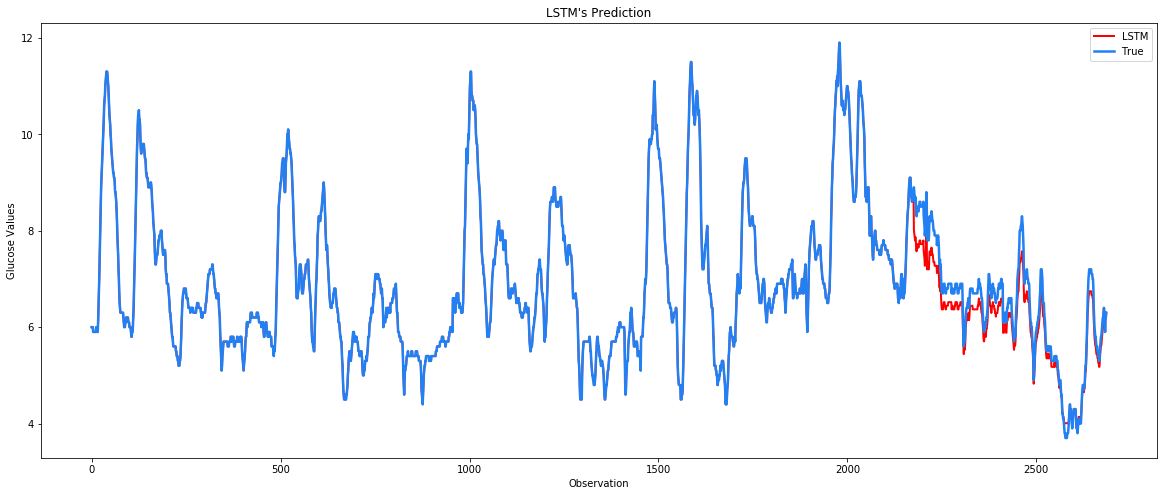

Index of Agreement is: 0.968
Mean Absolute Error is: 0.32983810535210095
Root Mean Squared Error is: 0.394
Mean Absolute Difference is: [0.6687137]
Fractional Bias is: 0.05
Mean Absolute Percentage Error is: 5.0


In [17]:
predicted, true = testModel(lstmModel,gap_tester_prediabetic)

for i in range(0,501):
    prediabetic_faulty['glucoseValue'][start+i] = predicted[i][0]
    
plot(prediabetic_faulty['glucoseValue'].tolist(),prediabetic['glucoseValue'].tolist())
getMetrics(predicted,true)
prediabetic_faulty.to_csv("~/Desktop/NCSA_genomics/Data/outputs/CGM_prediabetic_imputed.csv")

In [18]:
#repeating the same for non-diabetic
start, end = createGap(non_diabetic)
gap_tester_non_diabetic = non_diabetic.iloc[start:end+2]
non_diabetic_faulty = faultyData(non_diabetic_faulty,start,end+1)

501/501 [==============================] - 0s 802us/step
LSTM: 0.004477


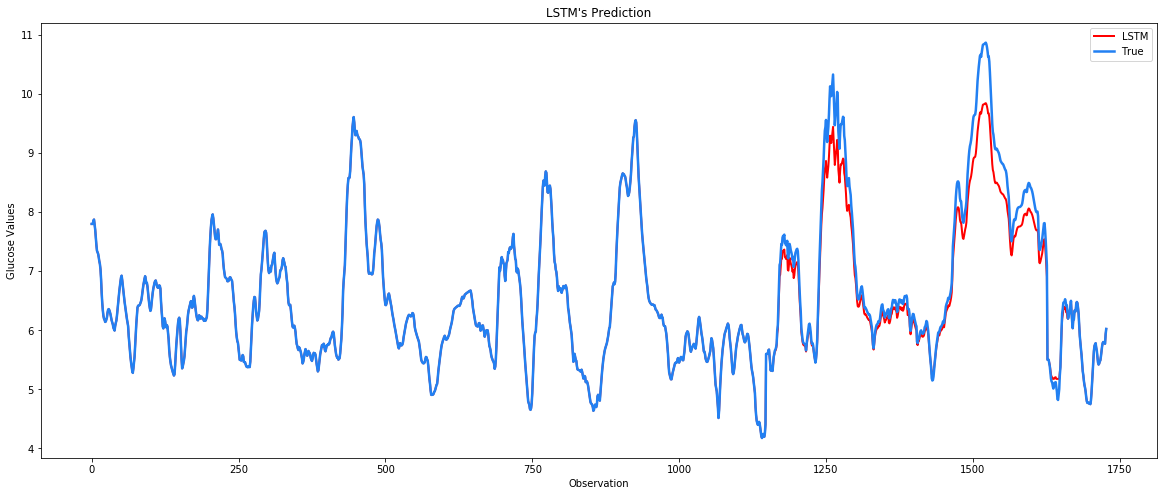

Index of Agreement is: 0.978
Mean Absolute Error is: 0.3009053107393002
Root Mean Squared Error is: 0.405
Mean Absolute Difference is: [1.3908459]
Fractional Bias is: 0.037
Mean Absolute Percentage Error is: 4.0


In [20]:
predicted, true = testModel(lstmModel,gap_tester_non_diabetic)

for i in range(0,501):
    non_diabetic_faulty['glucoseValue'][start+i] = predicted[i][0]
    
plot(non_diabetic_faulty['glucoseValue'].tolist(),non_diabetic['glucoseValue'].tolist())
getMetrics(predicted,true)
non_diabetic_faulty.to_csv("~/Desktop/NCSA_genomics/Data/outputs/CGM_nondiabetic_imputed.csv")

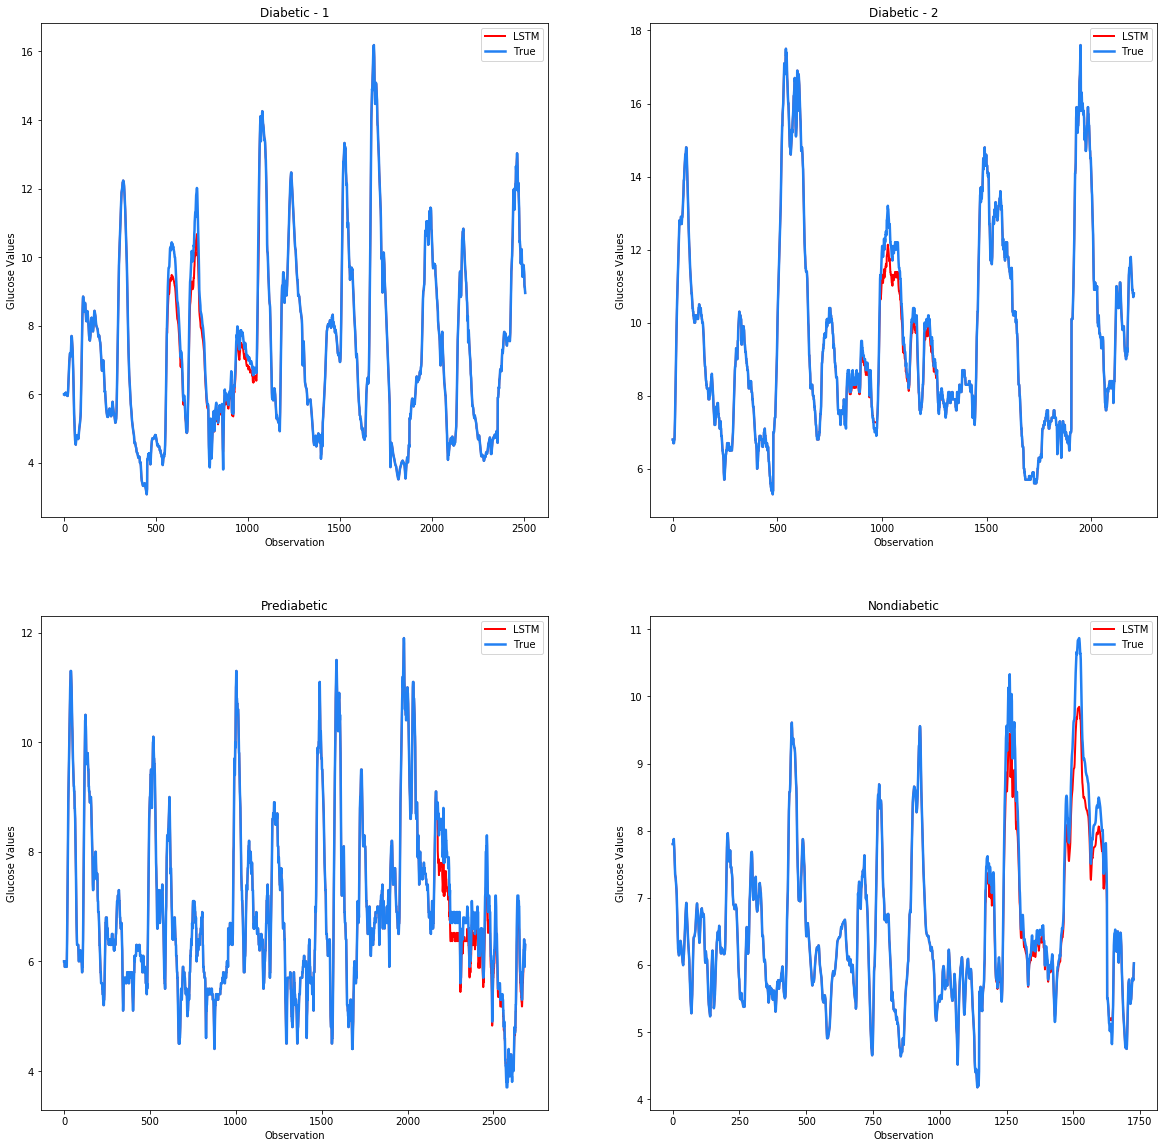

In [21]:
summaryPlot(diabetic_1_faulty['glucoseValue'].tolist(),diabetic_1['glucoseValue'].tolist(),diabetic_2_faulty['glucoseValue'].tolist(),diabetic_2['glucoseValue'].tolist(),prediabetic_faulty['glucoseValue'].tolist(),prediabetic['glucoseValue'].tolist(),non_diabetic_faulty['glucoseValue'].tolist(),non_diabetic['glucoseValue'].tolist())